#  Project on Stock Prediction :

Take stock price of any company you
want and predicts its price by using LSTM.
Use only Jupyter notebook code.

In [13]:
import numpy as np
import pandas as pd

#For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# For visualization
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

In [14]:
# Reading our dataset
df = pd.read_csv('preprocessed_CAC40.csv', parse_dates=['Date'])
df.head()

,Unnamed: 0,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
0,0,Accor,2020-04-03,22.99,23.40,23.40,22.99,67
1,1,Accor,2020-04-02,23.91,22.99,23.91,22.99,250
2,2,Accor,2020-04-01,24.10,23.83,24.10,23.83,37
3,3,Accor,2020-03-31,25.04,25.00,25.24,24.99,336
4,4,Accor,2020-03-30,26.50,25.02,26.50,24.99,415


# Explorartory Data Analysis

#### Preprocessing

In [15]:
# Dropping unnecessary column
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [16]:
# Defining a function that will contain stocks data for a specific company
def specific_data(company, start, end):
    company_data = df[df['Name'] == company]
    date_filtered_data = company_data[(company_data['Date'] > start) & (company_data['Date'] < end)]
    return date_filtered_data

In [17]:
# Selecting any random company out of our 'Name' column
company_name = random.choice(df['Name'].unique().tolist())
# Setting the start and end date
start_date=dt.datetime(2014,1,1)
end_date=dt.datetime(2020,1,1)

# Calling our function
specific_df = specific_data(company_name, start_date, end_date)

In [18]:
specific_df.head()

,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
83259,TOTAL,2019-12-30,49.49,49.53,49.53,49.10,"2,095"
83260,TOTAL,2019-12-27,49.50,49.39,49.85,49.30,"11,115"
83261,TOTAL,2019-12-23,49.21,49.22,49.22,48.91,"2,231"
83262,TOTAL,2019-12-20,48.91,49.31,49.32,48.91,"3,986"
83263,TOTAL,2019-12-19,48.94,49.10,49.10,48.75,"2,819"


# Visualization

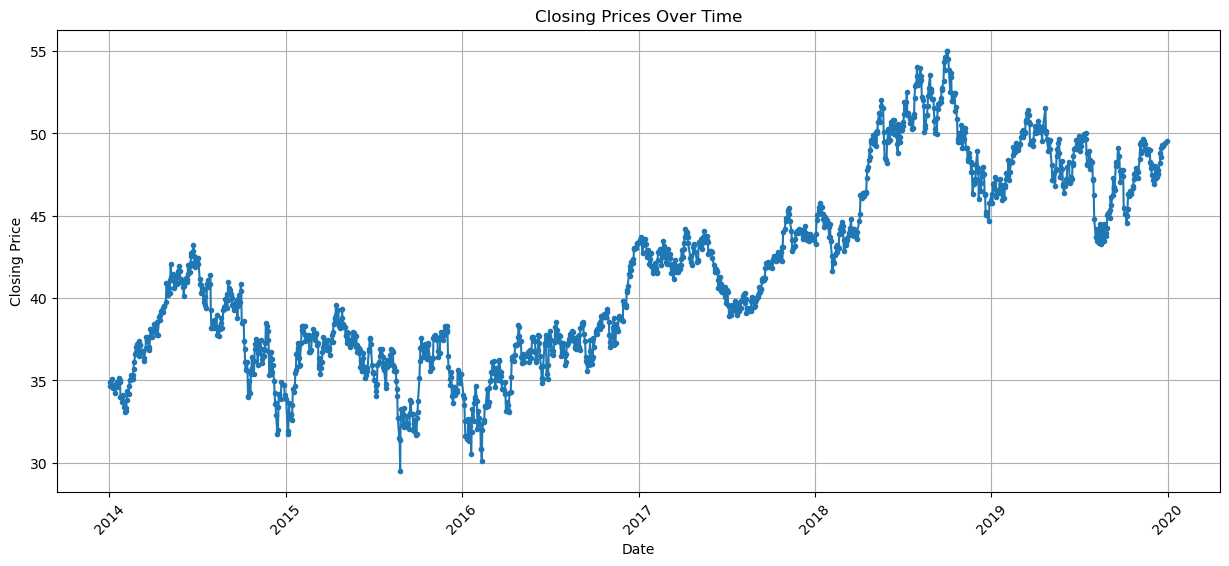

In [19]:
# Line Chart of Closing Prices Over Time

# Convert 'Date' column to datetime
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['Closing_Price'], marker='.')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

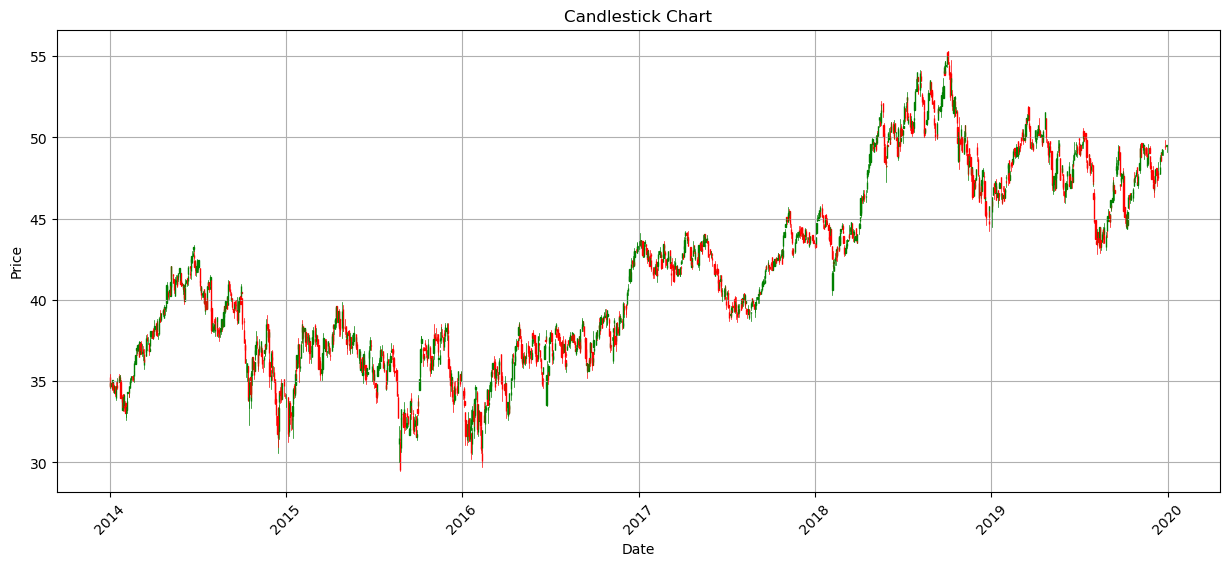

In [20]:
# Candlestick Chart

# Convert 'Date' column to matplotlib date format
matplotlib_date = mdates.date2num(specific_df['Date'])

# Create an array of tuples in the required format
ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['Daily_High'], specific_df['Daily_Low'], specific_df['Closing_Price'])).T

plt.figure(figsize=(15, 6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

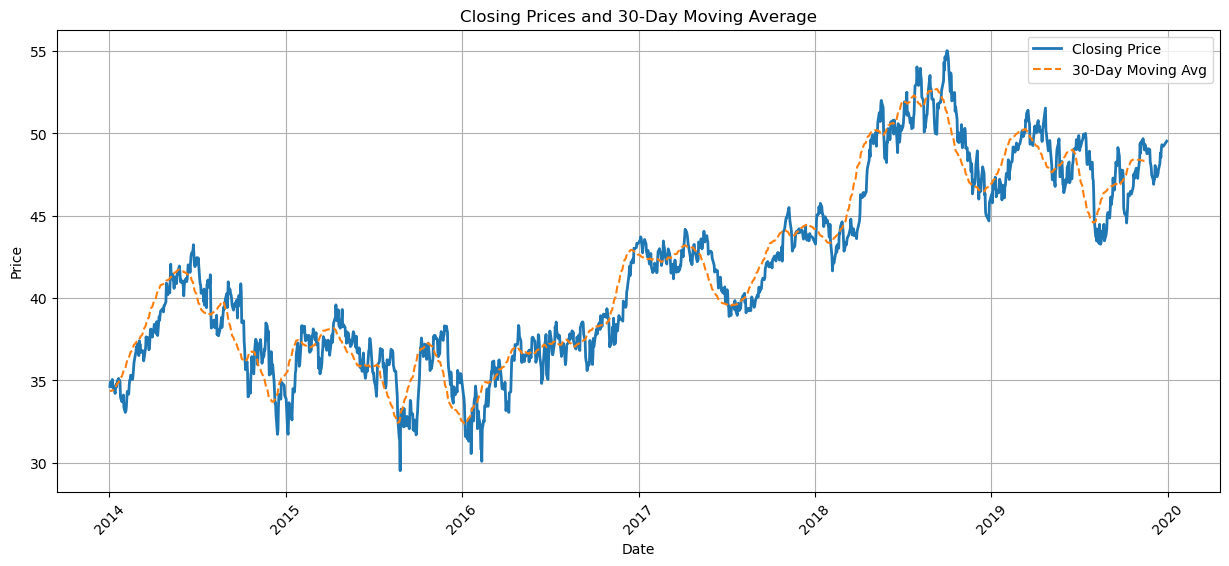

In [21]:
# Closing Prices and Moving Average plot

window = 30
plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['Closing_Price'], label='Closing Price', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Closing_Price'].rolling(window=window).mean(), label=f'{window}-Day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

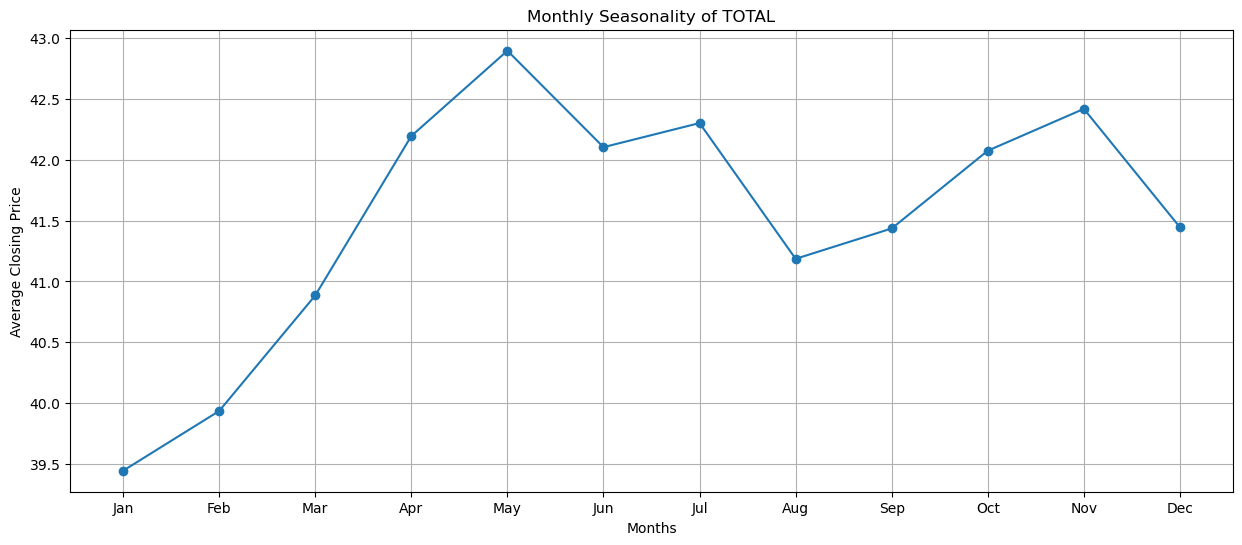

In [22]:
# Monthly Seasonality of Closing Prices
specific_df['Month'] = specific_df['Date'].dt.month

monthly_average = specific_df.groupby('Month')['Closing_Price'].mean()

plt.figure(figsize=(15, 6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title(f'Monthly Seasonality of {company_name}')
plt.xlabel('Months')
plt.ylabel('Average Closing Price')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

In [23]:
specific_df.head()

,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume,Month
83259,TOTAL,2019-12-30,49.49,49.53,49.53,49.10,"2,095",12
83260,TOTAL,2019-12-27,49.50,49.39,49.85,49.30,"11,115",12
83261,TOTAL,2019-12-23,49.21,49.22,49.22,48.91,"2,231",12
83262,TOTAL,2019-12-20,48.91,49.31,49.32,48.91,"3,986",12
83263,TOTAL,2019-12-19,48.94,49.10,49.10,48.75,"2,819",12


In [24]:
new_df = specific_df.reset_index()['Closing_Price']

In [25]:
# Normalizing our data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [26]:
# Split into training and testing sets
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [27]:
# Define the sequence length (number of past time steps)
n_past = 60

# Prepare sequences for LSTM
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [28]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)


Training set size:-
(1151, 60)
(1151,)


Testing set size:-
(243, 60)
(243,)


(None, None)

In [29]:
# Reshape input data for LSTM([samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Model training

In [30]:
# Initialize a sequential model
model = Sequential()

# First LSTM layer with 50 units, input shape, and return sequences
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))         # Adding dropout to prevent overfitting

# Second LSTM layer with 50 units and return sequences
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer with 50 units
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Add a dense output layer with one unit
model.add(Dense(units=1))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [32]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [33]:
# Defining our callbacks
checkpoints = ModelCheckpoint(filepath = 'my_weights.h5', save_best_only = True)
# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training our lstm model
model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

Epoch 1/100
36/36 [==============================] - 9s 96ms/step - loss: 0.0357 - val_loss: 0.0041
Epoch 2/100
 2/36 [>.............................] - ETA: 1s - loss: 0.0101

C:\Users\syedk\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 2s 62ms/step - loss: 0.0073 - val_loss: 0.0034
Epoch 3/100
36/36 [==============================] - 2s 64ms/step - loss: 0.0060 - val_loss: 0.0032
Epoch 4/100
36/36 [==============================] - 2s 61ms/step - loss: 0.0060 - val_loss: 0.0030
Epoch 5/100
36/36 [==============================] - 2s 59ms/step - loss: 0.0057 - val_loss: 0.0034
Epoch 6/100
36/36 [==============================] - 2s 62ms/step - loss: 0.0054 - val_loss: 0.0029
Epoch 7/100
36/36 [==============================] - 2s 63ms/step - loss: 0.0056 - val_loss: 0.0027
Epoch 8/100
36/36 [==============================] - 2s 65ms/step - loss: 0.0051 - val_loss: 0.0025
Epoch 9/100
36/36 [==============================] - 2s 63ms/step - loss: 0.0053 - val_loss: 0.0026
Epoch 10/100
36/36 [==============================] - 2s 63ms/step - loss: 0.0048 - val_loss: 0.0027
Epoch 11/100
36/36 [==============================] - 2s 61ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 12/1

In [34]:
# Let's do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 22ms/step


In [35]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [36]:
# Calculate train data RMSE
print(math.sqrt(mean_squared_error(y_train,train_predict)))
# Calculate test data RMSE
print(math.sqrt(mean_squared_error(y_test,test_predict)))

41.878099109340546
37.71675518699217


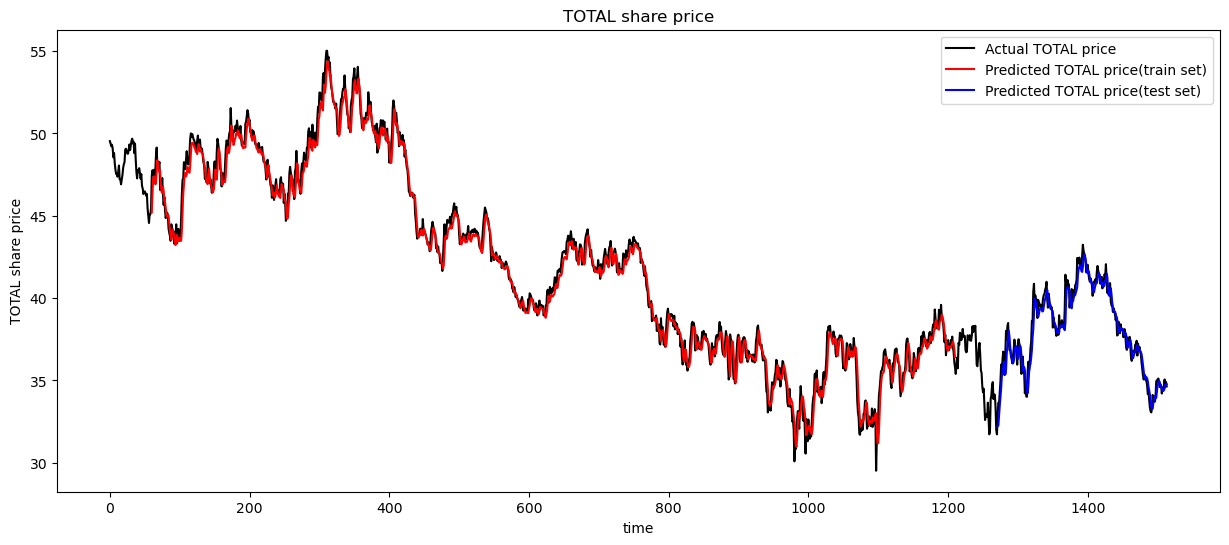

In [37]:
# Set the number of previous time steps to consider for plotting
look_back = 60

# Initialize an array for plotting the train predictions
trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:] = np.nan
# Assign the predicted values to the appropriate location for train predictions
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()

# Initialize an array for plotting the test predictions
testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
# Calculate the starting index for the test predictions
test_start = len(new_df) - len(test_predict)
# Assign the predicted values to the appropriate location for test predictions
testPredictPlot[test_start:] = test_predict.flatten()

# Rescale the scaled data back to its original scale using the scaler
original_scaled_data = scaler.inverse_transform(scaled_data)

# Plotting the baseline data, training predictions, and test predictions
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual {company_name} price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted {company_name} price(train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted {company_name} price(test set)")

plt.title(f"{company_name} share price")
plt.xlabel("time")
plt.ylabel(f"{company_name} share price")
plt.legend()
plt.show()


In [38]:
# To predict for the next 10 days, you'll need the last n_past days of data
last_sequence = X_test[-1]

# Reshape the last_sequence to match the input shape of the model
last_sequence = last_sequence.reshape(1, n_past, 1)

# Generate predictions for the next 10 days
predictions_next_10_days = []
for _ in range(10):
    next_day_prediction = model.predict(last_sequence)
    predictions_next_10_days.append(next_day_prediction[0, 0])  # Get the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=1)  # Shift the sequence by one day
    last_sequence[0, -1, 0] = next_day_prediction  # Update the last element with the new prediction

# Transform the predictions back to the original scale
predictions_next_10_days = scaler.inverse_transform(np.array(predictions_next_10_days).reshape(-1, 1))

# Print the predictions for the next 10 days
print("Predictions for the next 10 days:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")

1/1 [==============================] - 0s 28ms/step
Predictions for the next 10 days:
Day 1: Predicted Price = 34.77752685546875
Day 2: Predicted Price = 34.757225036621094
Day 3: Predicted Price = 34.715816497802734
Day 4: Predicted Price = 34.669158935546875
Day 5: Predicted Price = 34.62350845336914
Day 6: Predicted Price = 34.581451416015625
Day 7: Predicted Price = 34.54411697387695
Day 8: Predicted Price = 34.51171875
Day 9: Predicted Price = 34.483856201171875
Day 10: Predicted Price = 34.45976638793945


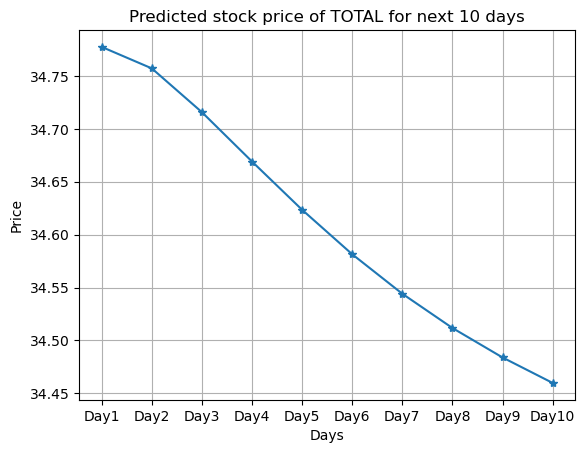

In [39]:
plt.plot(predictions_next_10_days, marker='*')
plt.title(f'Predicted stock price of {company_name} for next 10 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 10), ['Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10'])
plt.grid(True)
plt.show()